In [1]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
DATA_FOLDER='../../data/'

In [2]:
#Import datasets
# We work on the full data here, importing original datasets. 
df = pd.concat([pd.read_csv(f'{DATA_FOLDER}interactions_{typ}.csv') 
                          for typ in ['train', 'validation', 'test']])
pp_recipes = pd.read_csv(f'{DATA_FOLDER}PP_recipes.csv')
raw_recipes = pd.read_csv(f'{DATA_FOLDER}RAW_recipes.csv')

## Demographic filtering 
We first would like to output the best rated recipes, where "best rated" is defined via a special metric introduced by Imbd. To do so, we first need to update a bit the original datasets, including new columns like the mean rating and the number of ratings of a recipe.
The aim of this method consists in being able to recommend recipes to users when they provide no or few information about recipes they have tried and liked (e.g new users). 

In [3]:
# Mean rating of recipes, across all users and all recipes
mean_rating = df['rating'].mean()  # outputs a single value

# Count the number of ratings each recipe receives 
data = df.groupby('i')['rating'].count()
# We previously checked that recipe indexing go from 0 to 178264 without jumps (in all datasets).  
# Make it a dataframe
data = pd.DataFrame(data)
data.columns = ['vote_count'] 

# Compute the average rating of each recipe
my_list = pp_recipes['i'].tolist()
my_list.sort()
av_ratings = []
for item in my_list: 
    df_bis = df[df['i']==item]
    av_ratings.append(df_bis['rating'].mean())
# Returns a list with the average rating of each recipe
# Make it a dataframe
av_ratings = pd.DataFrame(av_ratings)
av_ratings.columns = ['vote_average']

# Merge - obtain a dataframe with vote_count and vote_average, for each recipe
data2 = data.join(av_ratings)
# Check it corresponds, trying several combinations and comparing with dataframe. 
df[df['i']==5]

,user_id,recipe_id,date,rating,u,i
254749,135017,254596,2007-09-29,5.0,12,5
261343,224088,254596,2007-10-21,4.0,13,5
275375,582223,254596,2007-12-09,5.0,14,5


In [4]:
# Add a recipe 'id' column so that we can find recipes' names later on
data2 = data2.join(pp_recipes['id']) 

# Define variables wrt to above definition 
m = data2['vote_count'].quantile(0.9)  # Minimum of 8 ratings for a recipe to be considered
C = mean_rating # simply rename 

# Def weighted ratings! It's a metric introduced by Imbd, which is more accurate than simple ratings.  
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

# Delete observations where the recipe does not satisfy the requirement 
q_recipes = data2.copy().loc[data2['vote_count'] >= m]
q_recipes.shape  # q_recipes is becoming our reference dataset 

# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_recipes['score'] = q_recipes.apply(weighted_rating, axis=1)

## Biggest successes 

In [7]:
# Sort recipes based on SCORE calculated above
q_recipes = q_recipes.sort_values('score', ascending=False)

##  Add name recipe and print the top 15 recipes
final_reco = q_recipes.iloc[:15,:]  # take 15 best recipes to make it computationnally easier (already sorted)

# Design a method to get the names of these recipes, using raw_recipes and the 'id' column
def getName(X):
    "Add the name of each recipe to dataframe X"
    id_target = []
    id_target = X['id'].tolist()  # list id of these recipes
    # Get name of those recipes using raw data
    name_recipes=[]
    for item in id_target: 
        a = raw_recipes[raw_recipes['id']== item].name.tolist()
        name_recipes = name_recipes + a
    # Add the name column   
    X['name_recipes']= name_recipes
    return X

# Apply it 
getName(final_reco) 


# Modify recommendations. Exclude recipes that are too similar to each other (include only one), based on a threshold. 
# Use of cosine similarity for this (comes back to using linear_kernel in this case)
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

def DelSimilarRecipes(X):
    # Convert names of recipes to tokens 
    tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
    tfidf_matrix = tf.fit_transform(X['name_recipes'])
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix) # create matrix with all similarity scores
    # Loop over all rows of the similarity matrix, deleting in original dataset the recipe whose similarity score is above a threshold 
    l =[]
    for i in range(0, cosine_sim[0].size):
        for j in range(i+1,cosine_sim[0].size): 
            if cosine_sim[i,:][j]>0.1: 
                l.append(j)
                #print('a recipe was deleted') # help us check how many recipe we delete
    X = X.drop(X.index[l])
    return X

# Aplpy it 
final_reco = DelSimilarRecipes(final_reco) # 13 obs remaining 

# Store recipe 'i' (=index here) of those that are recommended
final_reco = final_reco.iloc[:10,:]
reco = final_reco.index.values.tolist()

# Print list of recommendation ! Only BEST RATED RECIPE (WEIGHTED rating)
final_reco[['vote_count', 'vote_average', 'score', 'name_recipes']]


/Users/alexandreduval/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,vote_count,vote_average,score,name_recipes
i,,,,
88353,56,5.000000,4.945562,sesame glazed walnut shrimp
31024,48,5.000000,4.937785,live food crackers
163100,39,5.000000,4.925871,scrambled egg casserole
165216,63,4.968254,4.922760,basted eggs
81311,60,4.966667,4.919352,pumpkin white chocolate chip cookies
170673,35,5.000000,4.918976,no fail easy cake mix brownies
11325,34,5.000000,4.917047,frozen chocolate pb graham cracker bars 4 ing...
5589,32,5.000000,4.912899,stuffed vienna bread
96770,32,5.000000,4.912899,jo mama s world famous lasagna


In [10]:
#### Instead, PICK RANDOMLY among best 100 recipes to diversify a bit more. 
final_reco2 = q_recipes.iloc[:100,:]
r= set(final_reco2.index.tolist()).intersection(reco)    # we prevent the system to display recipes already recommended
if r != set():
    final_reco2= final_reco2.drop(reco)
#final_reco2 = final_reco2.drop(reco)
final_reco2 = final_reco2.sample(n=15) # select randomly 15 recipes

# use function def above to get name    
getName(final_reco2)

# Use above function to delete similar recipes
final_reco2 = DelSimilarRecipes(final_reco2) # 2 recipes deleted

# Save the recipes that are recommended.
final_reco2 = final_reco2.iloc[:10,:]
reco2 = final_reco2.index.values.tolist()

# Print list of recommendation ! It changes every time you run it.
print(final_reco2[['vote_count', 'vote_average', 'score','name_recipes']])

        vote_count  vote_average     score  \
i                                            
175772          27      5.000000  4.900456   
54631           45      4.933333  4.877660   
20086           24      5.000000  4.891124   
170105          21      5.000000  4.879861   
89589           50      4.960000  4.905448   
78501           23      5.000000  4.887611   
78026           38      4.947368  4.880782   
96746           21      5.000000  4.879861   
9513            23      5.000000  4.887611   
148452         101      4.930693  4.903816   

                                         name_recipes  
i                                                      
175772  steak with red peppers and sun dried tomatoes  
54631                 sarah s chopped apricot cookies  
20086            milanesa   cuban chicken fried steak  
170105                           apple cider pancakes  
89589                         nif s no fail pork ribs  
78501                       sweet heat cucumber salad  

Text(0.5, 1.0, 'Popular recipes')

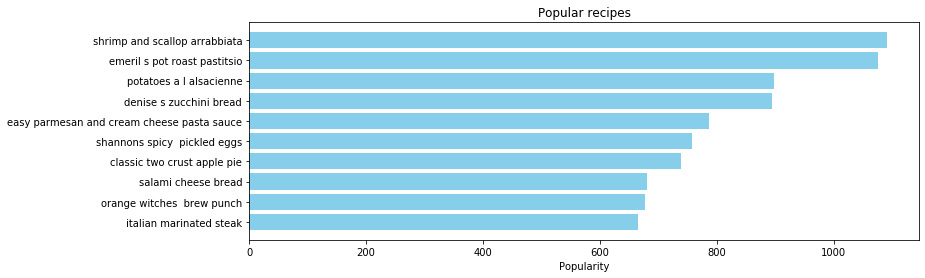

In [11]:
#### Give only MOST POPULAR recipes 

# Use vote count as a proxy for popularity
final_reco3= q_recipes.sort_values('vote_count', ascending=False).iloc[:1000,:]
r= set(final_reco3.index.tolist()).intersection((reco+reco2))    
if r != set():
    final_reco3 = final_reco3.drop(r)   # 4 datapoints are dropped
    # print('some datapoints were dropped')

# use function to get names of recipes
getName(final_reco3)

# Use above function to delete similar recipes
final_reco3 =DelSimilarRecipes(final_reco3)  # many recipes are deleted, 155 left

# Save recipes recommended
final_reco3 = final_reco3.iloc[:10,:]
reco3 = final_reco3.index.values.tolist()

# Print final list of recommendations ! 
final_reco3[['vote_count', 'vote_average', 'score', 'name_recipes']]

# Visualise it (nice)
pop= final_reco3.sort_values('vote_count', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['name_recipes'].head(15),pop['vote_count'].head(10), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular recipes")

## Add filters
We would like to filter a bit the recipes we recommend, based on their tag, the time they take, the amount of calorie they contain... 
This could help recommend more customised recipes, while still maximising the weighted rating. 

In [ ]:
####### Add some filters 

"""
# TAGS --> NO. Too complicated. Too many! Need some serious NLP i guess
tags=[]
for i in range(1,len(raw_recipes)):
    tags.append(raw_recipes['tags'][i])
    
tags = ','.join(tags)
    
def Convert(string): 
    li = list(string.split(" ")) 
    return li 
tags2= Convert(tags)
"""

## Diet 

In [12]:
## CALORY LEVEL (0,1,2)

pp_recipes[pp_recipes['calorie_level'] == 0].shape # reduce to 69k recipes. Low calorie recipe only. 
# Keep only best 30 recipes among the ones presenting a low calorie level
low_calorie = pp_recipes[pp_recipes['calorie_level'] == 0]['id'].tolist()
# Dataset reduced to 7K recipes, many low calorie level recipes are not rated enough times to appear in q_recipes
final_reco4 = q_recipes[q_recipes['id'].isin(low_calorie)]  # keep only recipes whose 'id' is in low calorie 
final_reco4 = final_reco4.sort_values(by='score', ascending=False).iloc[:30,:] 

# Prevent the model to display recipes already recommended
r = set(final_reco4.index.tolist()).intersection((reco+reco2+reco3))    
if r != set():
    final_reco4= final_reco4.drop(r) # 6 datapoints were deleted

# Get name of recipes
getName(final_reco4)  # dim = 24

# Delete similar recipes among the ones we would like to recommend
final_reco4 = DelSimilarRecipes(final_reco4)     # 13 recipes were judged too similar

# Save recipes recommended
final_reco4 = final_reco4.iloc[:10,:]
reco4 = final_reco4.index.values.tolist()

# Print reco 
final_reco4[['vote_count', 'vote_average', 'score', 'name_recipes']]


,vote_count,vote_average,score,name_recipes
i,,,,
361,39,4.974359,4.904595,corn and polenta fritters
123563,39,4.974359,4.904595,surf and turf stuffed mushrooms
84680,59,4.949153,4.903223,spicy cucumbers
153976,28,5.000000,4.903221,soft chocolaty cookies weight watchers
175206,26,5.000000,4.897528,custard cream filling
39272,35,4.971429,4.895720,jq meat balls for spaghetti sauce
13467,25,5.000000,4.894423,very berry salad
107375,43,4.953488,4.892470,hot apple cider
163792,41,4.951220,4.888081,becky s baked tomatoes with basil and parmesan


## Quick cooking 

In [13]:
### MINUTES

# Intuition
raw_recipes['minutes'].quantile(0.1) # 10min or less - 10% of recipes are kept

# Consider recipes that take 15min or less to prepare
short_recipes = raw_recipes[raw_recipes['minutes'] < 15]['id'].tolist()
final_reco5= q_recipes[q_recipes['id'].isin(short_recipes)] # dimension much smaller (972) as many recipes are not included in q_recipes
final_reco5= final_reco5.sort_values(by='score', ascending=False).iloc[:50,:]


# Prevent the model to display recipes already recommended
r = set(final_reco5.index.tolist()).intersection((reco+reco2+reco3+reco4))    
if r != set():
    final_reco5= final_reco5.drop(r)  # 2 elements are deleted. len(r)

# Get names of recipes 
getName(final_reco5)

# Delete similar recipes among the ones we would like to recommend
final_reco5 = DelSimilarRecipes(final_reco5)   # 26 obs are deleted.


# Save recipes recommended
final_reco5 = final_reco5.iloc[:10,:]
reco5 = final_reco5.index.values.tolist()

# Print reco 
final_reco5[['vote_count', 'vote_average', 'score', 'name_recipes']]


,vote_count,vote_average,score,name_recipes
i,,,,
120123,59,4.932203,4.888298,a snack for cream cheese and veggie fans
45374,49,4.938776,4.886245,mrs dash seasoning
80022,40,4.950000,4.885749,guilt free guacamole asparagus
114569,22,5.000000,4.883865,garam masala hot mixed spice
66337,21,5.000000,4.879861,broccoli cranberry salad
38291,21,5.000000,4.879861,downeaster
82528,29,4.965517,4.878810,you must make this dressing
32812,20,5.000000,4.875570,ranch tartar sauce
23221,20,5.000000,4.875570,parmesan pine cone


## New releases

In [17]:
# DATE SUBMISSION 
 
 
q_recipes = q_recipes.join(df['date']) 
final_reco6 = q_recipes.sort_values(by='date', ascending=False).iloc[:20,:]

# Prevent the model to display recipes already recommended
r = set(final_reco6.index.tolist()).intersection((reco+reco2+reco3+reco4+reco5))    
if r != set():
    final_reco6= final_reco6.drop(r)  # drop 1 

# Get names
getName(final_reco6)

# Delete similar recipes among the ones we would like to recommend
final_reco6 = DelSimilarRecipes(final_reco6)   # 6 obs are deleted.

# Save recipes recommended
final_reco6 = final_reco6.iloc[:10,:]
reco6 = final_reco6.index.values.tolist()

# Print reco 
final_reco6[['vote_count', 'vote_average', 'score', 'name_recipes', 'date']]

,vote_count,vote_average,score,name_recipes,date
9454,8,5.000000,4.782247,shrimp and sausage jambalaya,2018-12-06
1443,10,5.000000,4.806442,hamburger beef jerky,2018-11-30
9465,16,4.750000,4.688165,ashley s pecan squares,2018-10-23
9238,11,4.727273,4.658735,chicken or turkey salad,2018-10-20
9107,14,4.500000,4.523453,spicy corn,2018-10-09
3083,11,5.000000,4.816629,healthy microwave apple crisp,2018-09-20
5932,10,4.400000,4.473109,four cheese spinach quiche,2018-09-16
9920,13,5.000000,4.834093,tattie scones,2018-07-24
11965,18,4.333333,4.404460,honey pine nut coffee cake,2018-04-13
11136,11,4.727273,4.658735,jalapeno cowboy beans,2018-03-26
